In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

In [186]:
from typing import Tuple
import numpy as np

import autoarray as aa
from autogalaxy.profiles.mass.abstract.abstract import MassProfile

class PIEMD(MassProfile):

    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        ell_comps: Tuple[float, float] = (0.0, 0.0),
        ra: float = 0.1,
        b0: float = 0.1,
    ):
        super().__init__(centre=centre, ell_comps=ell_comps)

        self.ra = ra
        self.b0 = b0

    def _ci05(self,x, y, eps, rc):
        # Calculate intermediate values
        if eps < 1e-10:
            eps = 1e-10
        sqe = np.sqrt(eps)
        cx1 = (1.0 - eps) / (1.0 + eps)
        cxro = (1.0 + eps) * (1.0 + eps)
        cyro = (1.0 - eps) * (1.0 - eps)
        rem2 = x * x / cxro + y * y / cyro
        
        # Define complex numbers
        zci = np.complex128(complex(0.0, -0.5 * (1.0 - eps * eps) / sqe))  # 标量复数
        znum = np.complex128(cx1 * x + 1j * (2.0 * sqe * np.sqrt(rc * rc + rem2) - y / cx1))
        zden = np.complex128(x + 1j * (2.0 * rc * sqe - y))
            
        # Perform complex division: zis = znum / zden
        norm = zden.real * zden.real + zden.imag * zden.imag  # |zden|^2
        if np.any(norm < 1e-10):
            raise ValueError("zden magnitude too small, risk of division by zero")
        zis_re = (znum.real * zden.real + znum.imag * zden.imag) / norm
        zis_im = (znum.imag * zden.real - znum.real * zden.imag) / norm
        zis = np.complex128(zis_re + 1j * zis_im)
        
        # Calculate ln(zis) = ln(|zis|) + i*Arg(zis)
        zis_mag = np.abs(zis)
        if np.any(zis_mag < 1e-10):
            raise ValueError("zis magnitude too small, risk of log(0)")
        zis_re = np.log(zis_mag)
        zis_im = np.angle(zis)
        zis = np.complex128(zis_re + 1j * zis_im)
        
        # Calculate zres = zci * ln(zis)
        zres = zci * zis
        
        return zres
    
    def _ellip(self):
        ellip = np.sqrt(self.ell_comps[0] ** 2 + self.ell_comps[1] ** 2)
        MAX_ELLIP = 0.99999
        return min(ellip, MAX_ELLIP)
    
    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def deflections_yx_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Calculate the deflection angles on a grid of (y,x) arc-second coordinates.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        ellip = self._ellip()

        factor = self.b0

        zis = self._ci05(
            x=grid[:, 1], y=grid[:, 0], eps=ellip, rc=self.ra
        )

        # This is in axes aligned to the major/minor axis
        deflection_x = zis.real
        deflection_y = zis.imag

        # And here we convert back to the real axes
        return self.rotated_grid_from_reference_frame_from(
            grid=np.multiply(factor, np.vstack((deflection_y, deflection_x)).T), **kwargs
        )

    def _mdci05(self, x, y, eps, rc, b0):
        # Prevent division by zero by setting a minimum value for eps
        if eps < 1e-10:
            eps = 1e-10

        # Calculate intermediate values
        sqe = np.sqrt(eps)  # Square root of ellipticity
        cx1 = (1.0 - eps) / (1.0 + eps)  # Scaling factor for x
        cx1inv = 1.0 / cx1  # Inverse of cx1
        cxro = (1.0 + eps) * (1.0 + eps)  # Denominator for x^2 term in rem^2
        cyro = (1.0 - eps) * (1.0 - eps)  # Denominator for y^2 term in rem^2
        ci = 0.5 * (1.0 - eps * eps) / sqe  # Constant for derivative calculations
        wrem = np.sqrt(rc * rc + x * x / cxro + y * y / cyro)  # Effective radius including core

        # Compute denominators for derivative terms
        den1 = 2.0 * sqe * wrem - y * cx1inv
        den1 = cx1 * cx1 * x * x + den1 * den1
        num2 = 2.0 * rc * sqe - y
        den2 = x * x + num2 * num2

        # Check for division by zero
        if np.any(den1 < 1e-10) or np.any(den2 < 1e-10):
            raise ValueError("Denominator too small, risk of division by zero")

        # Compute second derivatives
        didxre = ci * (
            cx1 * (2.0 * sqe * x * x / cxro / wrem - 2.0 * sqe * wrem + y * cx1inv) / den1
            + num2 / den2
        )
        didyre = ci * (
            (2.0 * sqe * x * y * cx1 / cyro / wrem - x) / den1
            + x / den2
        )
        didyim = ci * (
            (2.0 * sqe * wrem * cx1inv - y * cx1inv * cx1inv - 4.0 * eps * y / cyro
            + 2.0 * sqe * y * y / cyro / wrem * cx1inv) / den1
            - num2 / den2
        )

        # Construct Hessian matrix components
        a = b0 * didxre  # ∂²ψ/∂x²
        b = b0 * didyre  # ∂²ψ/∂x∂y
        c = b0 * didyre  # ∂²ψ/∂y∂x (equal to ∂²ψ/∂x∂y)
        d = b0 * didyim  # ∂²ψ/∂y²

        # Return Hessian matrix as (n, 2, 2) array: [[a, b], [c, d]]
        return a,b,c,d

    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def analytical_hessian_from(self, grid: 'aa.type.Grid2DLike', **kwargs):
        # Validate input grid
        grid = np.asarray(grid)
        if grid.ndim != 2 or grid.shape[1] != 2:
            raise ValueError("Grid must be a 2D array with shape (n, 2)")

        # Validate parameters
        ellip = self._ellip()
        if not isinstance(ellip, (float, np.floating)):
            raise ValueError("Ellipticity must be a valid float")
        if not isinstance(self.ra, (float, np.floating)) or self.ra < 0:
            raise ValueError("ra must be a positive float")
        if not isinstance(self.b0, (float, np.floating)):
            raise ValueError("b0 must be a valid float")

        # Compute Hessian matrix components
        hessian_xx, hessian_xy, hessian_yx, hessian_yy = self._mdci05(
            x=grid[:, 1], y=grid[:, 0], eps=ellip, rc=self.ra, b0=self.b0
        )
        # hessian = self.rotated_grid_from_reference_frame_from(
        #     grid = np.vstack((hessian_xx,hessian_xy)).T
        # )
        return hessian_yy, hessian_xy, hessian_yx, hessian_xx
    
    def analytical_magnification_2d_from(self, grid: 'aa.type.Grid2DLike', **kwargs):
        """
        Calculate the magnification for the PIEMD model on a grid of (y, x) coordinates.

        Parameters
        ----------
        grid : aa.type.Grid2DLike
            A 2D array of shape (n, 2) with (y, x) arc-second coordinates.
        **kwargs
            Additional arguments passed to hessian_from.

        Returns
        -------
        np.ndarray
            Array of shape (n,) containing the magnification at each grid point.
        """
        hessian_yy, hessian_xy, hessian_yx, hessian_xx = self.analytical_hessian_from(
            grid=grid
        )

        det_A = (1 - hessian_xx) * (1 - hessian_yy) - hessian_xy * hessian_yx

        return aa.Array2D(values=1.0 / det_A, mask=grid.mask)
    
class dPIEMD(MassProfile):

    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        ell_comps: Tuple[float, float] = (0.0, 0.0),
        ra: float = 0.0,
        rs: float = 2.0,
        b0: float = 0.1,
    ):
        super().__init__(centre=centre, ell_comps=ell_comps)

        if ra > rs:
            ra, rs = rs, ra

        self.ra = ra
        self.rs = rs
        self.b0 = b0

    def _ci05f(self, x, y, eps, rc, rcut):
        # Prevent division by zero by setting a minimum value for eps
        if eps < 1e-10:
            eps = 1e-10
        
        # Calculate intermediate values
        sqe = np.sqrt(eps)  # Square root of ellipticity
        cx1 = (1.0 - eps) / (1.0 + eps)  # Scaling factor for x
        cxro = (1.0 + eps) * (1.0 + eps)  # Denominator for x^2 term
        cyro = (1.0 - eps) * (1.0 - eps)  # Denominator for y^2 term
        rem2 = x * x / cxro + y * y / cyro  # Elliptical radius term

        # Define zci (complex constant)
        zci = np.complex128(complex(0.0, -0.5 * (1.0 - eps * eps) / sqe))

        # Compute complex numbers for rc
        znum_rc = np.complex128(cx1 * x + 1j * (2.0 * sqe * np.sqrt(rc * rc + rem2) - y / cx1))
        zden_rc = np.complex128(x + 1j * (2.0 * rc * sqe - y))

        # Compute complex numbers for rcut
        znum_rcut = np.complex128(cx1 * x + 1j * (2.0 * sqe * np.sqrt(rcut * rcut + rem2) - y / cx1))
        zden_rcut = np.complex128(x + 1j * (2.0 * rcut * sqe - y))

        # Compute zis_rc / zis_rcut = (znum_rc / zden_rc) / (znum_rcut / zden_rcut)
        # Using manual complex division: (aa + bb*i) / (cc + dd*i)
        aa = znum_rc.real * zden_rc.real - znum_rc.imag * zden_rcut.imag
        bb = znum_rc.real * zden_rcut.imag + znum_rc.imag * zden_rc.real
        cc = znum_rc.real * zden_rc.real - zden_rc.imag * znum_rcut.imag
        dd = znum_rc.real * zden_rc.imag + zden_rc.real * znum_rcut.imag

        norm = cc * cc + dd * dd
        if np.any(norm < 1e-10):
            raise ValueError("Denominator magnitude too small in zis_rc/zis_rcut, risk of division by zero")
        # Compute real and imaginary parts of zis_rc / zis_rcut
        aaa = (aa * cc + bb * dd) / norm
        bbb = (bb * cc - aa * dd) / norm

        # Compute zr = log(zis_rc / zis_rcut) = log(aaa + bbb*i)
        norm2 = aaa * aaa + bbb * bbb
        if np.any(norm2 < 1e-10):
            raise ValueError("zr magnitude too small, risk of log(0)")
        zr_re = np.log(np.sqrt(norm2))  # Real part: log(|zis_rc / zis_rcut|)
        zr_im = np.arctan2(bbb, aaa)  # Imaginary part: phase of zis_rc / zis_rcut
        zr = np.complex128(zr_re + 1j * zr_im)

        # Compute final result: zres = zci * zr
        zres = zci * zr

        return zres
    
    def _ellip(self):
        ellip = np.sqrt(self.ell_comps[0] ** 2 + self.ell_comps[1] ** 2)
        MAX_ELLIP = 0.99999
        return min(ellip, MAX_ELLIP)
    
    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def deflections_yx_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Calculate the deflection angles on a grid of (y,x) arc-second coordinates.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        ellip = self._ellip()
        factor = self.b0 * self.rs / (self.rs - self.ra)
        zis = self._ci05f(
            x=grid[:, 1], y=grid[:, 0], eps=ellip, rc=self.ra, rcut=self.rs
        )

        # This is in axes aligned to the major/minor axis
        deflection_x = zis.real
        deflection_y = zis.imag

        # And here we convert back to the real axes
        return self.rotated_grid_from_reference_frame_from(
            grid=np.multiply(factor, np.vstack((deflection_y, deflection_x)).T), **kwargs
        )
    
class dPIEMDSph(dPIEMD):

    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        ra: float = 0.1,
        rs: float = 2.0,
        b0: float = 1.0
    ):
        if ra > rs:
            ra, rs = rs, ra
        super().__init__(centre=centre, ell_comps=(0.0, 0.0))
        self.ra = ra
        self.rs = rs
        self.b0 = b0

    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def deflections_yx_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Calculate the deflection angles on a grid of (y,x) arc-second coordinates.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        X = self.ra
        Y = self.rs
        u = grid[:, 1] * grid[:, 1] + grid[:, 0] * grid[:, 0]
        factor = np.sqrt(u + X * X) - X - np.sqrt(u + Y * Y) +Y
        factor *= self.b0 * Y / (Y - X) / u

        # This is in axes aligned to the major/minor axis
        deflection_x = grid[:, 1] * factor
        deflection_y = grid[:, 0] * factor

        # And here we convert back to the real axes
        return self.rotated_grid_from_reference_frame_from(
            grid=np.multiply(1.0, np.vstack((deflection_y, deflection_x)).T), **kwargs
        )

In [187]:
import autolens as al
grid = al.Grid2D.uniform(
    shape_native=(100,100),
    pixel_scales=0.02
)

In [188]:
mass_piemd = PIEMD(
    centre=(0.0,0.0),
    ell_comps=(0.5,0.5),
    ra=0.0,
    b0=1.0
)

In [189]:
grid.shape

(10000, 2)

In [190]:
mass_piemd.analytical_hessian_from(grid=grid)

(array([0.03307723, 0.03165611, 0.03021953, ..., 0.03021953, 0.03165611,
        0.03307723]),
 array([0.0798555 , 0.07868606, 0.07743397, ..., 0.07743397, 0.07868606,
        0.0798555 ]),
 array([0.0798555 , 0.07868606, 0.07743397, ..., 0.07743397, 0.07868606,
        0.0798555 ]),
 array([0.19278822, 0.1955861 , 0.19841536, ..., 0.19841536, 0.1955861 ,
        0.19278822]))

In [191]:
mass_piemd.hessian_from(grid=grid,buffer=0.01)

(VectorYX2DIrregular([0.1129392 , 0.11130914, 0.10961204, ..., 0.10961204, 0.11130914,
        0.1129392 ]),
 VectorYX2DIrregular([0.11293267, 0.11359751, 0.11422048, ..., 0.11422048, 0.11359751,
        0.11293267]),
 VectorYX2DIrregular([0.11293113, 0.1135957 , 0.11421839, ..., 0.11421839, 0.1135957 ,
        0.11293113]),
 VectorYX2DIrregular([0.11293613, 0.11594312, 0.11903308, ..., 0.11903308, 0.11594312,
        0.11293613]))

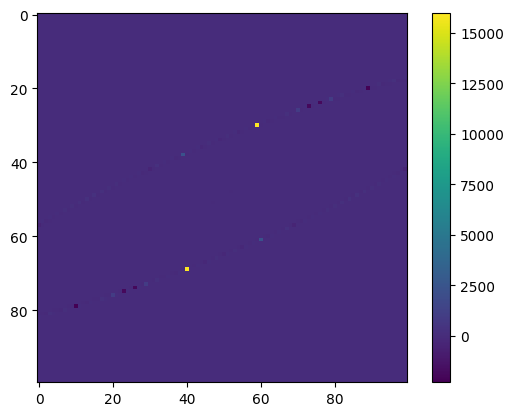

In [192]:
plt.imshow(mass_piemd.magnification_2d_from(grid=grid).native)
plt.colorbar()

In [215]:
np.mean(mass_piemd.magnification_2d_from(grid=grid).native/mass_piemd.analytical_magnification_2d_from(grid=grid).native)

1.1149997497015343

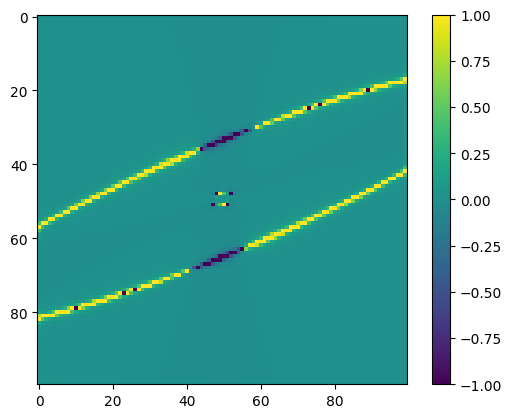

In [217]:
plt.imshow(mass_piemd.magnification_2d_from(grid=grid).native-mass_piemd.analytical_magnification_2d_from(grid=grid).native,vmax=1.0,vmin=-1.0)
plt.colorbar()

In [194]:
mass_piemd.magnification_2d_via_hessian_from(grid=grid)

ArrayIrregular([1.29177941, 1.29408113, 1.29641781, ..., 1.29641781, 1.29408113,
       1.29177941])

In [197]:
grid[1]

Grid2D([ 0.99, -0.97])

In [198]:
mass_dpiemd = dPIEMD(
    centre=(0.0,0.0),
    ell_comps=(0.5,0.5),
    ra=0.0,
    rs=10000,
    b0=1.0
)

In [199]:
mass_dpiemdsph = dPIEMDSph(
    centre=(0.0,0.0),
    ra=0.0,
    rs=10000,
    b0=1.0
)

In [200]:
mass_sie = al.mp.Isothermal(
    centre=(0,0),
    ell_comps=(0.5,0.5),
    einstein_radius=1.0
)

In [201]:
mass_sis = al.mp.IsothermalSph(
    centre=(0,0),
    einstein_radius=1.0
)

In [202]:
mass_sis.magnification_2d_via_hessian_from(grid=grid)

ArrayIrregular([3.49972898, 3.5908522 , 3.68780554, ..., 3.68780554, 3.5908522 ,
       3.49972898])

In [203]:
mass_piemd.deflections_yx_2d_from(grid=grid)[:,0]

VectorYX2D([ 0.60714059,  0.60940596,  0.61168421, ..., -0.61168421,
       -0.60940596, -0.60714059])

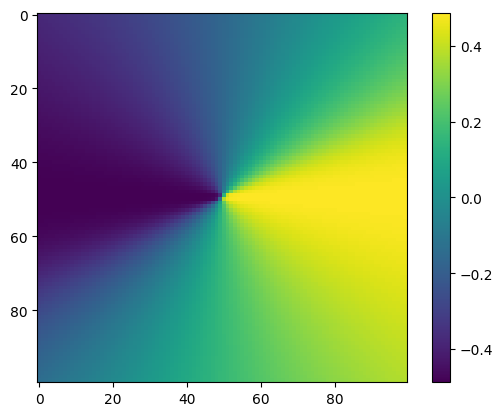

In [204]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(mass_piemd.deflections_yx_2d_from(grid=grid).native[:,:,1])
plt.colorbar()

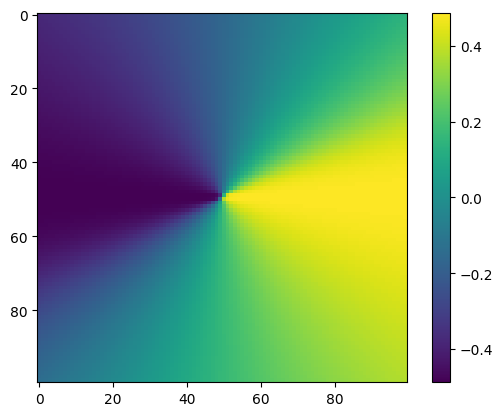

In [205]:
plt.imshow(mass_dpiemd.deflections_yx_2d_from(grid=grid).native[:,:,1])
plt.colorbar()

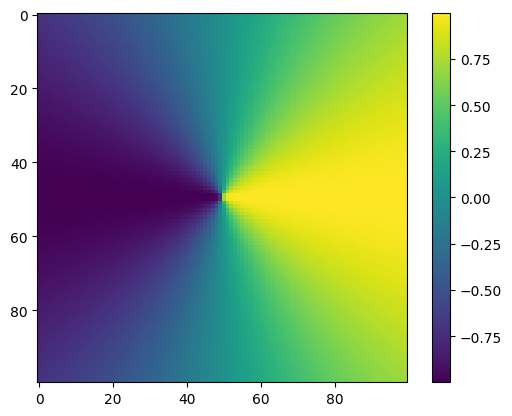

In [206]:
plt.imshow(mass_dpiemdsph.deflections_yx_2d_from(grid=grid).native[:,:,1])
plt.colorbar()

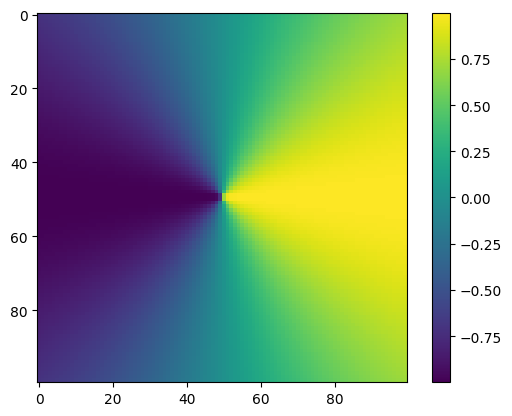

In [207]:
plt.imshow(mass_sis.deflections_yx_2d_from(grid=grid).native[:,:,1])
plt.colorbar()

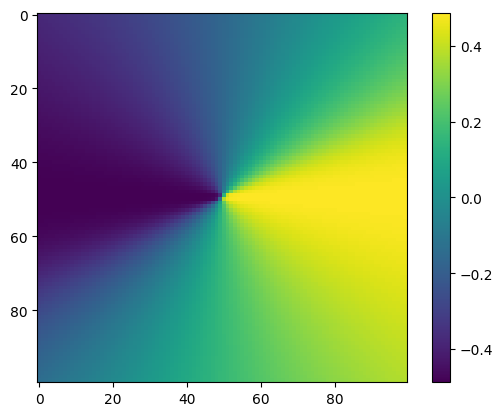

In [210]:
plt.imshow(mass_sie.deflections_yx_2d_from(grid=grid).native[:,:,1])
plt.colorbar()